# Light GBM & Parameter Tuning with Optuna

A critical step in machine learning is to identify the "best" hyper-parameter values for a model (such as the number of neighbours in a KNN model). In this tutorial, we illustrate how a good set of model hyper-parameters can be found within a cross-validation framework. The particular family of models we focus on is the Light GBM model, which is a high-performing popular ensemble method with several attractive features as discussed below. For tuning, we use the Optuna hyper-parameter tuning module due to its flexibility and good performance in general. For illustration of these concepts, we use the US Census Income Dataset for a binary classification problem.

In what follows, we first provide an overview of boosting, gradient boosting, and Light GBM. Then we illustrate how Light GBM's hyper-parameters can be fine-tuned by Optuna using the
US Census Income Dataset. We also discuss how the modelling & tuning results can be visualised.

## Table of Contents
- [Boosting, Gradient Boosting, and Light GBM](#lgbm)
- [Case Study & Light GBM Features](#case_study)
- [Hyper-parameter Tuning with Optuna](#optuna)
- [Evaluation & Visualisation of Results](#vis)

## Boosting, Gradient Boosting, and Light GBM  <a id='lgbm'></a>

**Reference:** *Fundamentals of Machine Learning for Predictive Data Analytics Algorithms, Worked Examples, and Case Studies* By John D. Kelleher, Brian Mac Namee and Aoife D’Arcy.


### Boosting

Boosting works by iteratively creating models and adding them to an ensemble, usually consisting of decision trees. The iteration stops when a predefined number of models have been added. In classical boosting such as ADABoost, each new model added to the ensemble is biased to pay more attention to instances that previous models misclassified. This is done by incrementally adapting the dataset used to train the models. To do this, we use a weighted dataset. Each instance has an associated weight $w_i \geq 0$, initially set to $1/n$ where n is the number of instances in the dataset. After each model is added to the ensemble, it is tested on the training data and the weights of the instances the model gets correct are decreased and the weights of the instances the model gets incorrect are increased. These weights are used as a distribution over which the dataset is sampled to created a replicated training set, where the replication of an instance is proportional to its weight. Once the set of models have been created, the ensemble makes predictions using a weighted aggregate of the predictions made by the individual models. The weights used in this aggregation are simply the confidence factors associated with each model.


### Gradient Boosting

Like simpler boosting algorithms, gradient boosting iteratively trains prediction models in an attempt to make later models specialize in areas that earlier models struggled with. Gradient boosting can be said to do so in a more aggressive way than the boosting algorithm described previously. In gradient boosting, later models are trained to **directly correct errors made by earlier models**, rather than the more subtle approach of simply changing weights in a sampling distribution. 

Although any model can be used at the model training steps in gradient boosting, it is most common to use relatively shallow decision trees. This is the same approach taken in random forests, which aims to combine a large number of weak learners into an overall strong learner.

### Light GBM Overview

Light GBM (Light Gradient Boosting Machine) is popular open-source tree-based boosting method developed and maintained by Microsoft. The 2017 NIPS Conference proceeding introducing this algorithm can be found [here](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf). Light GBM uses the leaf-wise tree growth algorithm, while many other popular methods such as Random Forests and XGBoost use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. 

Light GBM has many of XGBoost's advantages, including sparse optimization, parallel training, multiple loss functions, regularization, bagging, and early stopping. A major difference between the two lies in the construction of trees. Light GBM does not grow a tree level-wise (row by row) as most other implementations do. Instead, it grows trees leaf-wise. It chooses the leaf it believes will yield the largest decrease in loss. Besides, Light GBM does not use the widely-used sorted-based decision tree learning algorithm, which searches the best split point on sorted feature values, as XGBoost or other implementations do. Instead, Light GBM implements a highly optimized histogram-based decision tree learning algorithm, which yields great advantages on both efficiency and memory consumption ([source 1](https://en.wikipedia.org/wiki/LightGBM), [source 2](https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997)).

In a full-scale Light GBM vs. XGBoost comparison regarding income status prediction, it was observed that Light GBM was about 25 times faster than XGBoost while resulting in about the same model performance with respect to an f1-score.

## Case Study: Income Status Prediction & Light GBM Features <a id='case_study'></a>

### Getting Started

In this tutorial, we will work with the US Census Income Dataset from [UCI](https://archive.ics.uci.edu/ml/datasets/census+income). The data was taken from the 1994 US Census Database. The goal is to predict whether an individual earns more than $50,000 a year. We read in a cleaned version of this dataset with no missing values.

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [2]:
import requests
import io

# how to read a csv file from a github account
url_name = 'https://raw.githubusercontent.com/akmand/datasets/master/us_census_income_data_clean.csv'
url_content = requests.get(url_name, verify=False).content

df_raw = pd.read_csv(io.StringIO(url_content.decode('utf-8')))

df_raw = df_raw.rename(columns={'result': 'target'})

print(df_raw.shape)
print(df_raw.columns)

(45222, 12)
Index(['age', 'workclass', 'education_num', 'marital_status', 'occupation',
       'relationship', 'race', 'gender', 'hours_per_week', 'native_country',
       'capital', 'income_status'],
      dtype='object')


In [3]:
df = df_raw.copy()
df.head()

age         workclass  education_num      marital_status  \
0   39         state_gov             13       never_married   
1   50  self_emp_not_inc             13  married_civ_spouse   
2   38           private              9            divorced   
3   53           private              7  married_civ_spouse   
4   28           private             13  married_civ_spouse   

          occupation   relationship   race  gender  hours_per_week  \
0       adm_clerical  not_in_family  white    male              40   
1    exec_managerial        husband  white    male              13   
2  handlers_cleaners  not_in_family  white    male              40   
3  handlers_cleaners        husband  other    male              40   
4     prof_specialty           wife  other  female              40   

  native_country  capital income_status  
0  united_states     2174         <=50k  
1  united_states        0         <=50k  
2  united_states        0         <=50k  
3  united_states        0         <=50k  
4          other        0         <=50k

In [4]:
# let's have a look at the distribution of the target feature
df = df.rename(columns={'income_status': 'target'})
df['target'].value_counts()

target
<=50k    34014
>50k     11208
Name: count, dtype: int64

In [5]:
# we need to map the target feature so that 
# the positive class is 1 and the negative class is 0
df['target'] = np.where(df['target'] == "<=50k", 0, 1)
df['target'].value_counts()

target
0    34014
1    11208
Name: count, dtype: int64

## Data Preprocessing

Here, we need to make sure that we run the column filters **after** row filters, if any. Please note that the steps listed below are mostly generic. Let's first order the columns alphabetically for convenience.

In [6]:
df = df[sorted(df.columns)]

### Dropping Columns with a Single Value

In [7]:
unique_value_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1]
df = df.drop(columns=unique_value_cols)
print(df.shape)
print('columns dropped:')
print(unique_value_cols)

(45222, 12)
columns dropped:
[]


### Dropping Columns with Too Many Missing Values

In [8]:
# run this BEFORE the "too frequent" filter below to avoid undefined mode
cols_before_na_filter = df.columns
column_min_allowed_nonmissing_ratio = 0.50
#
df = df.dropna(axis=1, thresh=int(column_min_allowed_nonmissing_ratio*df.shape[0] + 1))
#
print(df.shape)
print('columns dropped:')
print(sorted(list(set(cols_before_na_filter) - set(df.columns))))

(45222, 12)
columns dropped:
[]


### Dropping Columns with Too Frequent Values

If a column's most frequent value is "too frequent" and there are enough number of levels, let's drop that column as it will probably not be very helpful for predictive modelling. Below, `eq()` checks for equality.

In [9]:
def get_unhelpful_cols(df, min_levels_threshold, freq_threshold):
    # get all columns that are objects
    # these are assumed to be **nominal** categorical
    Data = df.drop(columns = 'target')
    categorical_cols = Data.columns[Data.dtypes == object].tolist()
    return [col for col in categorical_cols if (df[col].nunique() >= min_levels_threshold) and 
            (df[col].eq(df[col].mode(dropna=True)[0]).mean() >= freq_threshold)]

In [10]:
# if there are at least 5 levels in a column and the most frequent level is at least 95% of the data, drop it
unhelpful_cols = get_unhelpful_cols(df, 5, 0.95)
#
df = df.drop(columns=unhelpful_cols)
print(df.shape)
print('columns dropped:')
print(unhelpful_cols)   

(45222, 12)
columns dropped:
[]


In [11]:
# if there are at least 2 levels in a column and the most frequent level is at least 99% of the data, drop it
unhelpful_cols = get_unhelpful_cols(df, 2, 0.99)
#
df = df.drop(columns=unhelpful_cols)
print(df.shape)
print('columns dropped:')
print(unhelpful_cols)    

(45222, 12)
columns dropped:
[]


### Dropping Columns with Too Many Levels

In [12]:
# if a column has too many levels, drop it
Data = df.drop(columns = 'target')
categorical_cols = Data.columns[Data.dtypes == object].tolist()
#
col_unique_value_threshold = 150
#
unhelpful_cols = [col for col in categorical_cols if (df[col].nunique() >= col_unique_value_threshold)]
df = df.drop(columns=unhelpful_cols)
print(df.shape)
print('columns dropped:')
print(unhelpful_cols)  

(45222, 12)
columns dropped:
[]


### Dropping Identical Columns

For datasets coming from database joins, sometimes there will be columns with different names that are essentially the same. We can use the value distributions to check for such columns and then keep only one of them if they turn out to be the same.

In [13]:
def get_identical_value_count_cols(df):
    return [(df.columns[col1], df.columns[col2]) for col1 in range(len(df.columns)) for col2 in range(col1+1, len(df.columns)) 
        if np.array_equal(df.iloc[:, col1].value_counts().values, df.iloc[:,col2].value_counts().values)]

In [14]:
df['foo'] = df['marital_status']

In [15]:
identical_value_cols = get_identical_value_count_cols(df)
print(identical_value_cols)
# placeholder:
identical_value_cols_to_drop = ['foo']
df = df.drop(columns=identical_value_cols_to_drop)

[('marital_status', 'foo')]


### Missing Values and Light GBM

A nice feature of Light GBM is that all features are discretized & binned behind the scenes, so Light GBM can **handle missing values natively**. However, for this to happen, missing values need to be set to `np.nan`.  This dataset has no missing values, but still, we can present the missing value results in a nice-looking HTML table.

In [16]:
print('missing value counts:')

cols_missing_values = df.isna().sum()
cols_missing_values[cols_missing_values > 0]

missing value counts:


Series([], dtype: int64)

In [17]:
print('shape before dropping rows with missing values:', df.shape)
df = df.dropna()
print('shape after:', df.shape)

shape before dropping rows with missing values: (45222, 12)
shape after: (45222, 12)


### Dropping Duplicate Rows

We need to drop duplicate rows at the very end in case some columns were dropped, potentially resulting in even more duplicate rows.

In [18]:
# drop duplicate WOs
print(df.shape)
df = df.drop_duplicates(keep="first")
print(df.shape)

(45222, 12)
(39123, 12)


### Feature Analysis - Numerical

In [19]:
df[df.columns[df.dtypes != object]].describe()

age  capital  education_num  hours_per_week   target
count 39123.00 39123.00       39123.00        39123.00 39123.00
mean     39.33  1155.50          10.14           41.21     0.25
std      13.30  8033.21           2.64           12.47     0.44
min      17.00 -4356.00           1.00            1.00     0.00
25%      29.00     0.00           9.00           40.00     0.00
50%      38.00     0.00          10.00           40.00     0.00
75%      48.00     0.00          13.00           45.00     1.00
max      90.00 99999.00          16.00           99.00     1.00

### Feature Analysis - Categorical

In [20]:
def print_cat_col_values(df, print_levels=True, print_perc=False, dont_print_more_than=20):
    
    cat_cols = df.columns[df.dtypes==object].tolist()
    
    if print_levels:
        if print_perc:
            print('printing percentage counts:\n')
        else:
            print('printing absolute counts:\n')
        
    for col in cat_cols:
        print(f'{col}: {df[col].nunique()} unique values')
        if print_levels:
            if print_perc:
                print(df[col].value_counts(normalize=True)[:dont_print_more_than]*100)
            else:
                print(df[col].value_counts()[:dont_print_more_than])
        print('########')    

In [21]:
print_cat_col_values(df, print_levels=True, print_perc=True)

printing percentage counts:

gender: 2 unique values
gender
male     66.47
female   33.53
Name: proportion, dtype: float64
########
marital_status: 7 unique values
marital_status
married_civ_spouse      45.71
never_married           30.98
divorced                15.03
separated                3.56
widowed                  3.22
married_spouse_absent    1.41
married_af_spouse        0.08
Name: proportion, dtype: float64
########
native_country: 2 unique values
native_country
united_states   90.18
other            9.82
Name: proportion, dtype: float64
########
occupation: 14 unique values
occupation
prof_specialty      14.08
exec_managerial     13.55
adm_clerical        12.07
sales               11.91
craft_repair        11.77
other_service       10.84
machine_op_inspct    6.20
transport_moving     5.19
handlers_cleaners    4.35
farming_fishing      3.64
tech_support         3.38
protective_serv      2.39
priv_house_serv      0.59
armed_forces         0.04
Name: proportion, dtype: float64

### Defining Descriptive and Target Features 

In [22]:
Data = df.drop(columns = 'target').copy()
target = np.array(df['target']).reshape(-1, 1)

# get all columns that are objects
# these are assumed to be **nominal** categorical
categorical_cols = Data.columns[Data.dtypes == object].tolist()

With Light GBM, we do **not** need One-Hot-Encoding (OHE) of categorical features. **HOWEVER**, we must set their data type to `category` for the algorithm to work properly.

In [23]:
Data[categorical_cols] = Data[categorical_cols].astype('category')

# let's verify the results
Data.dtypes

age                  int64
capital              int64
education_num        int64
gender            category
hours_per_week       int64
marital_status    category
native_country    category
occupation        category
race              category
relationship      category
workclass         category
dtype: object

### Handling of Categorical Features in Light GBM

*Nominal* categorical features have no natural ordering. Some examples are colours, make of cars, country names, etc. This is unlike *ordinal* categorical features such as credit ratings and course grades that do have a natural, inherent ordering.

In general, nominal categorical features need to be one-hot-encoded before fitting any prediction models. Light GBM is an exception to this rule as it can **handle (nominal) categorical features natively** without any encoding! **HOWEVER**, for this functionality to work, data type of nominal categorical features need to be set to Pandas' `category` data type. That is, a categorical feature whose data type is set to `category` will be treated as *nominal* categorical by Light GBM. 

On the other hand, ordinal categorical features whose values are strings need to be mapped correctly as integers, such as below:
- "Good" credit rating --> 3
- "OK" credit rating --> 2
- "Bad" credit rating --> 1

Once this mapping is done, Light GBM will handle them correctly (just like any other numerical feature).

### Under the Hood for Categorical Features

As mentioned above, Light GBM can handle nominal categorical features natively once their data type is set to `category`. Internally, Light GBM splits categorical features into just two groups while growing a boosting tree ([source](https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features)). In order to find the optimal split, it considers only a small number of splits controlled by the following parameters:
- `min_data_per_group`: (default: 100) Minimum number of observations withing a group.
- `max_cat_threshold`: (default: 32) Maximum number of split points considered during a (binary) categorical feature split.
- `max_cat_to_onehot`: (default: 4) By default, if a feature has 4 or less number of levels, Light GBM will split it into 2 by the best of all the one-vs-all_other_levels split candidates.

The main idea with splitting a categorical feature is to sort the categories according to the training objective at each split. Light GBM sorts this feature's histogram based on its accumulated values and then finds the best split on the sorted histogram.


### Handling of Numerical Features
Light GBM discretizes all numerical features behind the scenes for the binary splits. This binning is based on these numerical features' histograms. Number of bins is controlled by the parameters below:
- `max_bin`: (default: 255) Maximum number of bins the numerical features will be bucketed in. Smaller number of bins might help with speed as well as over-fitting.
- `min_data_in_bin`: (default: 3) Minimum number of observations in a bin.

### Light GBM Practical Advantages

Several practical advantanges of Light GBM are as follows:

1. Unlike Scikit-Learn, Light GBM works with Pandas dataframes natively, eliminating the back-forth conversion between Numpy arrays and Pandas dataframes during the modelling & deployment phases.

2. With Light GBM, it is straightforward to **deal with the class imbalance issue with the use of a single parameter**. Specifically, Light GBM defines `is_unbalance` which can be set to `True` for classification problems with class imbalance. Setting this parameter to True increases the weight of the positive class inversely proportional to its frequency in the training data.

3. Controlling over-fitting is relatively simple with Light GBM with the use of validation data. Light GBM allows for definition of a validation dataset to avoid over-fitting during training. This way, the training can be stopped early when the performance on the validation dataset stops improving.

4. We can still fall back on classical Random Forests while still technically using Light GBM by setting the `boosting` parameter to `random_forest`.

The way missing values and nominal categorical/ numerical features are handled in Light GBM also eliminates several issues in practice:

5. There is no action needed for missing values - other than setting them to `np.nan`.
> - Neither for numerical nor categorical features. 
> - Neither for training data nor test data nor for observations to be predicted during deployment.

6. There is no need for encoding of any (nominal) categorical features. 
> - Neither for training data nor test data nor for observations to be predicted during deployment. 
> - This eliminates the especially tricky situation in deployment wherein a categorical feature has a missing value or contains a level that was not present in the training dataset.

7. There is no need for bundling or eliminating rare levels in a categorical feature.
>- Light GBM splits categorical features into just two groups using a specialized algorithm, so neither of the above will be necessary in general.

8. For regression problems, Light GBM allows for "**linear trees**" at the leaf nodes, which tend to produce better predictions due to the continuous nature of regression problems.

### Train-Test Split

Let's split the descriptive features and the target feature into a training set and a test set by a ratio of 70:30. That is, we use 70 % of the data for building **and tuning** a Light GBM classifier and then we evaluate its performance on the test set.

In [24]:
from sklearn.model_selection import train_test_split

# target is already encoded as 1: high income, 0: low income

Data_train, Data_test, t_train, t_test = train_test_split(Data, 
                                                    target, 
                                                    test_size = 0.3, 
                                                    stratify=target,
                                                    random_state=999)
print(f"Data.shape: {Data.shape}")
print(f"Data_train.shape: {Data_train.shape}")
print(f"Data_test.shape: {Data_test.shape}")

Data.shape: (39123, 11)
Data_train.shape: (27386, 11)
Data_test.shape: (11737, 11)


### Utility Function for Printing Results
We define the utility function below to print various metrics for a binary classifier.

In [25]:
from sklearn import metrics

def print_stats(clf, clf_name, Data_test, t_test, pr_threshold=0.5):
    #
    t_pred = (clf.predict_proba(Data_test)[:,1] >= pr_threshold).astype(int)
    #
    print(f"classifier: {clf_name}")
    print(f"pr_threshold: {pr_threshold}")
    print(f"accuracy : {metrics.accuracy_score(t_test, t_pred):.2f}")
    print(f"recall   : {metrics.recall_score(t_test, t_pred):.2f}")
    print(f"precision: {metrics.precision_score(t_test, t_pred):.2f}")
    print(f"f1-score : {metrics.f1_score(t_test, t_pred):.2f}")
    #
    # must pass in the proba's to roc_auc_score(), not the predictions!
    t_prob = clf.predict_proba(Data_test)
    print(f"roc-auc  : {metrics.roc_auc_score(t_test, t_prob[:,1]):.2f}")
    print("-----------")
    print("confusion matrix:")
    print(metrics.confusion_matrix(t_test, t_pred))

### Fitting LGBM with Defaults Modified

Let's fit a Light GBM with default values changed to fit the problem at hand. Specifically, let's do the following:
- `is_unbalance` = True
- `max_bin` = 100
- `min_data_in_bin` = 10

To be clear, these parameters will be **permanently fixed** to the above values and they will not be tuned. This is primarily for illustration purposes to show how certain parameters can be changed from their default values without tuning.

In [26]:
%%time

import lightgbm as lgbm

clf_name = 'Light GBM'

lgbm_params_fixed = {"objective": "binary",                      
                     "max_bin": 100, 
                     "min_data_in_bin": 10,
                     "is_unbalance": True}

clf = lgbm.LGBMClassifier(**lgbm_params_fixed)

clf.fit(Data_train, t_train);

[LightGBM] [Info] Number of positive: 6973, number of negative: 20413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 27386, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254619 -> initscore=-1.074126
[LightGBM] [Info] Start training from score -1.074126
CPU times: user 386 ms, sys: 399 ms, total: 785 ms
Wall time: 536 ms


### (Untuned) Model Performance on Train Data

In [27]:
pr_threshold = 0.5
print_stats(clf, clf_name, Data_train, t_train, pr_threshold=pr_threshold)

classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.85
recall   : 0.90
precision: 0.64
f1-score : 0.75
roc-auc  : 0.94
-----------
confusion matrix:
[[16891  3522]
 [  681  6292]]


### (Untuned) Model Performance on Test Data

In [28]:
pr_threshold = 0.5
print_stats(clf, clf_name, Data_test, t_test, pr_threshold=pr_threshold)

classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.83
recall   : 0.86
precision: 0.62
f1-score : 0.72
roc-auc  : 0.92
-----------
confusion matrix:
[[7144 1605]
 [ 405 2583]]


## Hyper-parameter Tuning with Optuna <a id='optuna'></a>

### Optuna Overview

Optuna is a popular framework for hyper-parameter tuning of prediction algorithms. In addition to its good performance & easy parallelization in general, it offers a great deal of flexibility in terms of the search algorithm used for the tuning. Specifically, Optuna allows for the following samplers:
- Random search (similar to that of Scikit-Learn)
- Grid search (similar to that of Scikit-Learn)
- Tree-structured Parzen Estimator (TPE) algorithm: (default sampler) This is a Bayesian independent-sampling based algorithm that uses the ratio of Gaussian Mixture Model (GMM) values for guiding the search.
- Covariance Matrix Adaptation Evolution Strategy (CMA-ES) based algorithm: CMA-ES is a stochastic method for real-parameter optimisation of nonlinear, non-convex functions. 


Some important Optuna terminology is as follows:

- `Trial:` A single call of the objective function to be optimised, that is, one objective function measurement.
- `Study:` An optimisation session, which is a set of trials.
- `Parameter:` A variable whose value is to be optimised.

In Optuna, the "study" object is used to manage optimisation. Method `create_study()` returns a study object. A study object has useful properties for analyzing the optimization outcome, such as `best_params`.

### LightGBM Parameters

LightGBM [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html) lists several dozen parameters, but the more important ones are listed below:

- `num_iterations:` (default: 100) Number of trees in the ensemble, i.e., boosting iterations. Internally, LightGBM constructs `num_class * num_iterations` trees for multi-class classification problems.
- `learning_rate:` (default: 0.1) Shrinkage rate (weights of the boosting trees). This is the incremental contribution of the subsequent boosting trees in the ensemble for the final prediction.
- `num_leaves:` (default: 31) This is the main parameter to control the complexity of the tree model.
- `min_child_samples (aliased to min_data_in_leaf):` (default: 20) This is an important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. 
>- **NOTE:** Light GBM does not like the name `min_data_in_leaf`, so we will need to use the name `min_child_samples` for this parameter.
- `min_gain_to_split:` (default : 0) When adding a new tree node, Light GBM chooses the split point that has the largest gain. Gain is the reduction in training loss that results from adding a split point. By default, Light GBM sets min_gain_to_split to 0.0, which means "there is no improvement that is too small". However, in practice, very small improvements in the training loss may not have a meaningful impact on the generalization error of the model. Thus, increasing this parameter may reduce training time with minimal impact on performance.
- `max_depth:` (default: -1) Limits the max depth for tree model. This can be used to deal with over-fitting for small datasets. 

### Parameter Ranges with Optuna 

In Optuna, a trial is one objective function measurement. This object is passed to an objective function and it provides interfaces to get best parameter values, manage the trial's state, and set/ get user-defined attributes of the trial. Parameters of different kinds can be specified as follows:
- `trial.suggest_categorical(name, choices)`
- `trial.suggest_int(name, low, high [, step])`
- `trial.suggest_float(name, low, high [, step])`

### Defining the Grid and Objective Function
We first define an objective function with **cross-validated** log loss as our performance metric for guiding the tuning process. The `LightGBMPruningCallback()` below from Optuna's integration module identifies unpromising hyper-parameter sets beforehand and reduces the search time significantly.

In [29]:
# !pip install optuna
# !pip install optuna-integration

import optuna  
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

NUM_CV_FOLDS = 10
EARLY_STOPPING_ROUNDS = 50
EVAL_METRIC = "binary_logloss"

def objective_fn(trial, Data, target, lgbm_params_fixed):
    
    grid_params = {
    "num_iterations": trial.suggest_int("num_iterations", 50, 150, step=10),
    "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 50, step=5),
    "min_child_samples": trial.suggest_int("min_child_samples", 20, 500, step=20),
    # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    # "max_depth": trial.suggest_int("max_depth", 3, 12),
    # ## for fun, we can also tune the L2 regularisation parameter
    # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    }

    # add the fixed params to the grid params to be passed in to the classifier
    grid_params.update(lgbm_params_fixed)
    
    cv = StratifiedKFold(n_splits=NUM_CV_FOLDS, 
                         shuffle=True, 
                         random_state=999)
    
    cv_scores = np.empty(NUM_CV_FOLDS)
    
    for idx, (train_idx, valid_idx) in enumerate(cv.split(Data, target)):
        
        Data_train, Data_valid = Data.iloc[train_idx], Data.iloc[valid_idx]
        
        t_train, t_valid = target[train_idx], target[valid_idx]

        model = lgbm.LGBMClassifier(**grid_params)

        model.fit(
            Data_train,
            t_train,
            eval_set=[(Data_valid, t_valid)], # this is the validation dataset
            eval_metric=EVAL_METRIC,
            # early_stopping_rounds doesn't work here in recent versions of LightGBM...
            # early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            callbacks=[LightGBMPruningCallback(trial, EVAL_METRIC)],
            # verbose=False  # add this if you don't want to see training logs
        )
        
        t_pred = model.predict_proba(Data_valid)
        cv_scores[idx] = log_loss(t_valid, t_pred)

    return np.mean(cv_scores)

In [30]:
# tuning with TPE

optuna_study = optuna.create_study(direction="minimize", 
                                   sampler=optuna.samplers.TPESampler(), # default sampler is TPE
                                   # sampler=optuna.samplers.RandomSampler(seed=999), # random sampler can also be used                                  
                                   study_name="Light GBM Tuning with TPE")

[I 2024-07-22 23:55:47,627] A new study created in memory with name: Light GBM Tuning with TPE


#### Digression: Grid Search

We can also perform a grid search with Optuna. For this, we need to define a "search space" that contains the grid values as a list for each hyper-parameter to be tuned, which is illustrated below.

In [31]:
# optional: tuning with grid search

optuna_search_space = {"num_iterations": [50, 75, 100, 125, 150],
                       "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
                       "num_leaves": [20, 30, 40, 50],
                       "min_child_samples": [20, 100, 300, 500]
                      }

# note that this grid study is NOT used in this notebook
optuna_study_grid_foo = optuna.create_study(direction="minimize", 
                                   sampler=optuna.samplers.GridSampler(optuna_search_space),
                                   study_name="Light GBM Tuning with Grid Search")

[I 2024-07-22 23:55:47,632] A new study created in memory with name: Light GBM Tuning with Grid Search


### Random Sampling of the Training Data for Ease of Computation

Tuning many hyper-parameters with a lot of data can take a lot of time! In many cases, training with a relatively smaller subset of the original training data can significantly reduce the search time with minimal impact on the performance.

In [32]:
print(f"original training data number of rows: {len(Data_train)}")

TRAIN_SAMPLE_SIZE = 20_000

Data_train_subset = pd.DataFrame(Data_train).sample(TRAIN_SAMPLE_SIZE, random_state=999)
t_train_subset = pd.Series(t_train.flatten()).sample(TRAIN_SAMPLE_SIZE, random_state=999).values.reshape(-1, 1)

print(f"training data number of rows after sampling: {len(Data_train_subset)}")

original training data number of rows: 27386
training data number of rows after sampling: 20000


### Running the Tuner
Let's run the tuner and then have a look at the results. Here, we can set a time limit in seconds, `timeout`, or put a limit on the number of sampling iterations, `n_trials`. We can also invoke parallel processing by setting `n_jobs` to the number of parallel runs.

In [33]:
TIME_LIMIT = 30  # in seconds
NUM_JOBS_TUNING = 3 # for parallel processing

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
%%time

optuna_trial = lambda trial: objective_fn(trial, 
                                         Data_train_subset, 
                                         t_train_subset, 
                                         lgbm_params_fixed)

optuna_study.optimize(optuna_trial,
                      timeout=TIME_LIMIT,
                      n_jobs=NUM_JOBS_TUNING)

optuna_study.optimize(optuna_trial, timeout=TIME_LIMIT, n_jobs=NUM_JOBS_TUNING)


In [35]:
print(f"Best objective function value: {optuna_study.best_value:.5f}")

optuna_study.best_params

Best objective function value: 0.33561


{'num_iterations': 70,
 'learning_rate': 0.21814689773767665,
 'num_leaves': 35,
 'min_child_samples': 80}

We can view the results as a Pandas data frame as well.

In [36]:
df_tuning_results = optuna_study.trials_dataframe().sort_values(by=['value'])
print(df_tuning_results.shape)
df_tuning_results.head(5)

(36, 10)


number  value             datetime_start          datetime_complete  \
34      34   0.34 2024-07-22 23:56:48.693303 2024-07-22 23:56:58.885379   
35      35   0.34 2024-07-22 23:56:53.309243 2024-07-22 23:56:59.656499   
0        0   0.34 2024-07-22 23:55:47.644084 2024-07-22 23:56:03.522618   
16      16   0.34 2024-07-22 23:56:26.592096 2024-07-22 23:56:38.282620   
2        2   0.34 2024-07-22 23:55:47.646373 2024-07-22 23:55:58.492548   

                 duration  params_learning_rate  params_min_child_samples  \
34 0 days 00:00:10.192076                  0.22                        80   
35 0 days 00:00:06.347256                  0.22                        40   
0  0 days 00:00:15.878534                  0.09                        60   
16 0 days 00:00:11.690524                  0.21                       100   
2  0 days 00:00:10.846175                  0.22                        80   

    params_num_iterations  params_num_leaves     state  
34                     70                 35  COMPLETE  
35                     60                 30  COMPLETE  
0                     100                 35  COMPLETE  
16                     70                 35  COMPLETE  
2                      70                 35  COMPLETE

### Optimisation Hot Start

A nice feature of Optuna is that it allows for a "hot-start" for the optimisation process. In particular, the study object retains the optimisation history, so when we call the `optimize()` function again, the search continues where it was left off.

In [ ]:
%%time

# second round of optimisation
optuna_study.optimize(optuna_trial, 
                      timeout=TIME_LIMIT,
                      n_jobs=NUM_JOBS_TUNING)

In [38]:
print(f"Second round best objective function value: {optuna_study.best_value:.5f}")

optuna_study.best_params

Second round best objective function value: 0.33557


{'num_iterations': 50,
 'learning_rate': 0.24575209319219002,
 'num_leaves': 40,
 'min_child_samples': 40}

### Tuning Commentary

Some rough guidelines for tuning are listed below.
- Light GBM usually gives very good results with the default parameters already. For this reason, hyper-parameter fine tuning might not bring much to the table, at least not for Light GBM.
- Sometimes the Random Sampler can be as competitive as the more fancy samplers such as TPE or CMA-ES.
- In case the best value for a hyper-parameter is one of the end points of the defined search range, it may be a good idea to extend the range in that direction to see if even better results might be achieved.
- In general, each additional hyper-parameter to be tuned increases the size of the search space significantly, so an iterative approach might make more sense. For instance, we might first search over a few important hyper-parameters, and then fix their values to the best found thus far, and then continue the search over a few other hyper-parameters. Of course, optimality is not guaranteed in this case, but it might help with reducing the search time.

## Evaluation & Visualisation of Results <a id='vis'></a>

### Evaluation of the Model with Tuned Parameters

Let's train a new model with the best parameters using the train dataset and evaluate it on the test dataset.

In [39]:
clf_name = 'Light GBM'

lgbm_params_tuned = optuna_study.best_params

clf_tuned = lgbm.LGBMClassifier(**lgbm_params_fixed, **lgbm_params_tuned)

clf_tuned.fit(Data_train, t_train);

[LightGBM] [Info] Number of positive: 6973, number of negative: 20413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 27386, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254619 -> initscore=-1.074126
[LightGBM] [Info] Start training from score -1.074126


### Tuned Model Performance on Train Data

In [40]:
pr_threshold = 0.5
print_stats(clf_tuned, clf_name, Data_train, t_train, pr_threshold=pr_threshold)

classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.85
recall   : 0.91
precision: 0.65
f1-score : 0.76
roc-auc  : 0.95
-----------
confusion matrix:
[[17020  3393]
 [  621  6352]]


### Tuned Model Performance on Test Data

In [41]:
pr_threshold = 0.5
print_stats(clf_tuned, clf_name, Data_test, t_test, pr_threshold=pr_threshold)

classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.83
recall   : 0.86
precision: 0.62
f1-score : 0.72
roc-auc  : 0.92
-----------
confusion matrix:
[[7163 1586]
 [ 420 2568]]


### Precision-Recall Curve

For our final model, the trade-off between precision and recall can be visualised through a precision-recall curve as shown below.

In [42]:
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import shap 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn-v0_8")

plt.rcParams["figure.figsize"] = (10,6)

def display_pr_curve(clf, clf_name, Data_test, t_test):
    t_prob = clf.predict_proba(Data_test)
    display = PrecisionRecallDisplay.from_predictions(t_test.ravel(), t_prob[:, 1], name=clf_name)
    _ = display.ax_.set_title("Precision-Recall Curve")

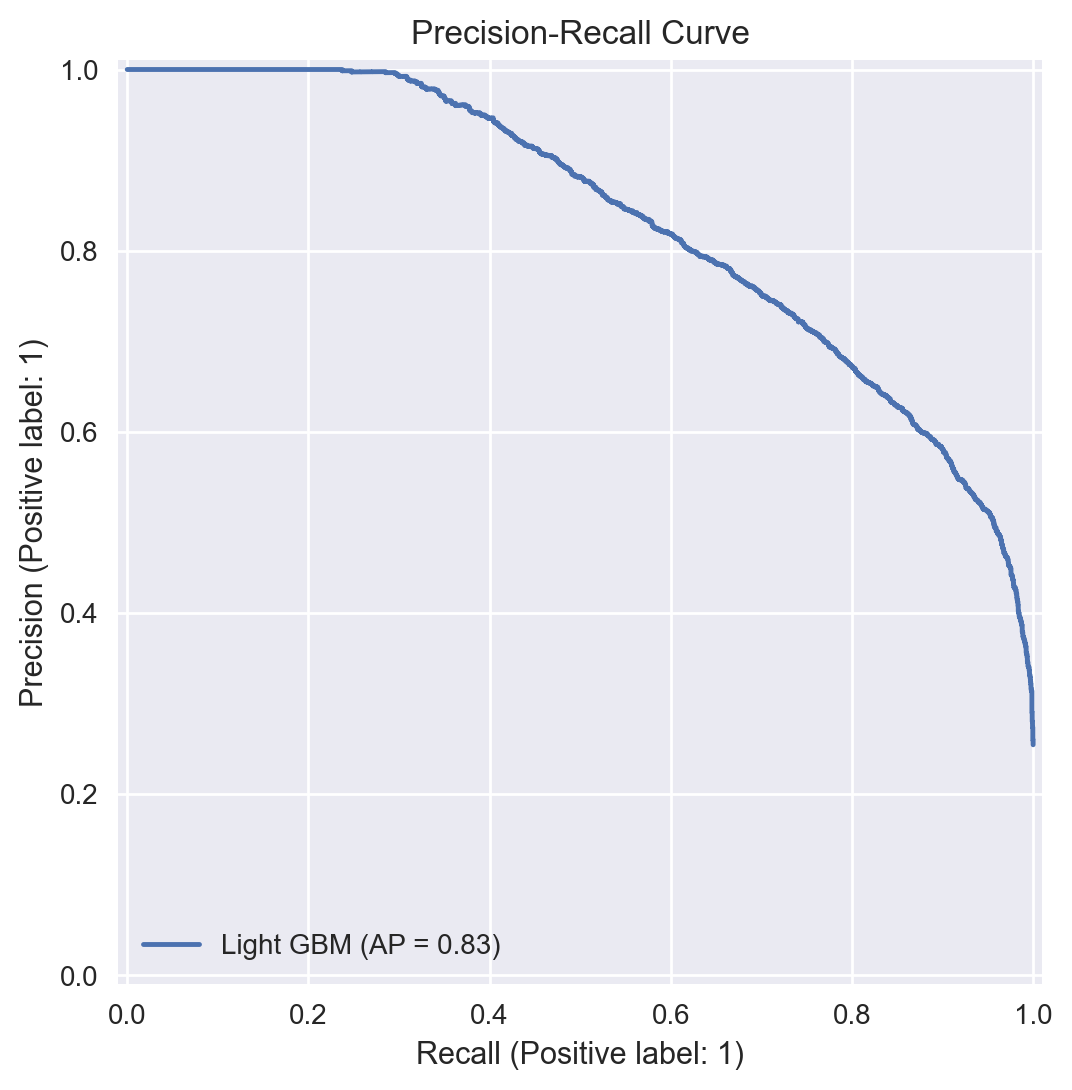

In [43]:
display_pr_curve(clf, clf_name, Data_test, t_test)

### Visualisation of Model Feature Importances

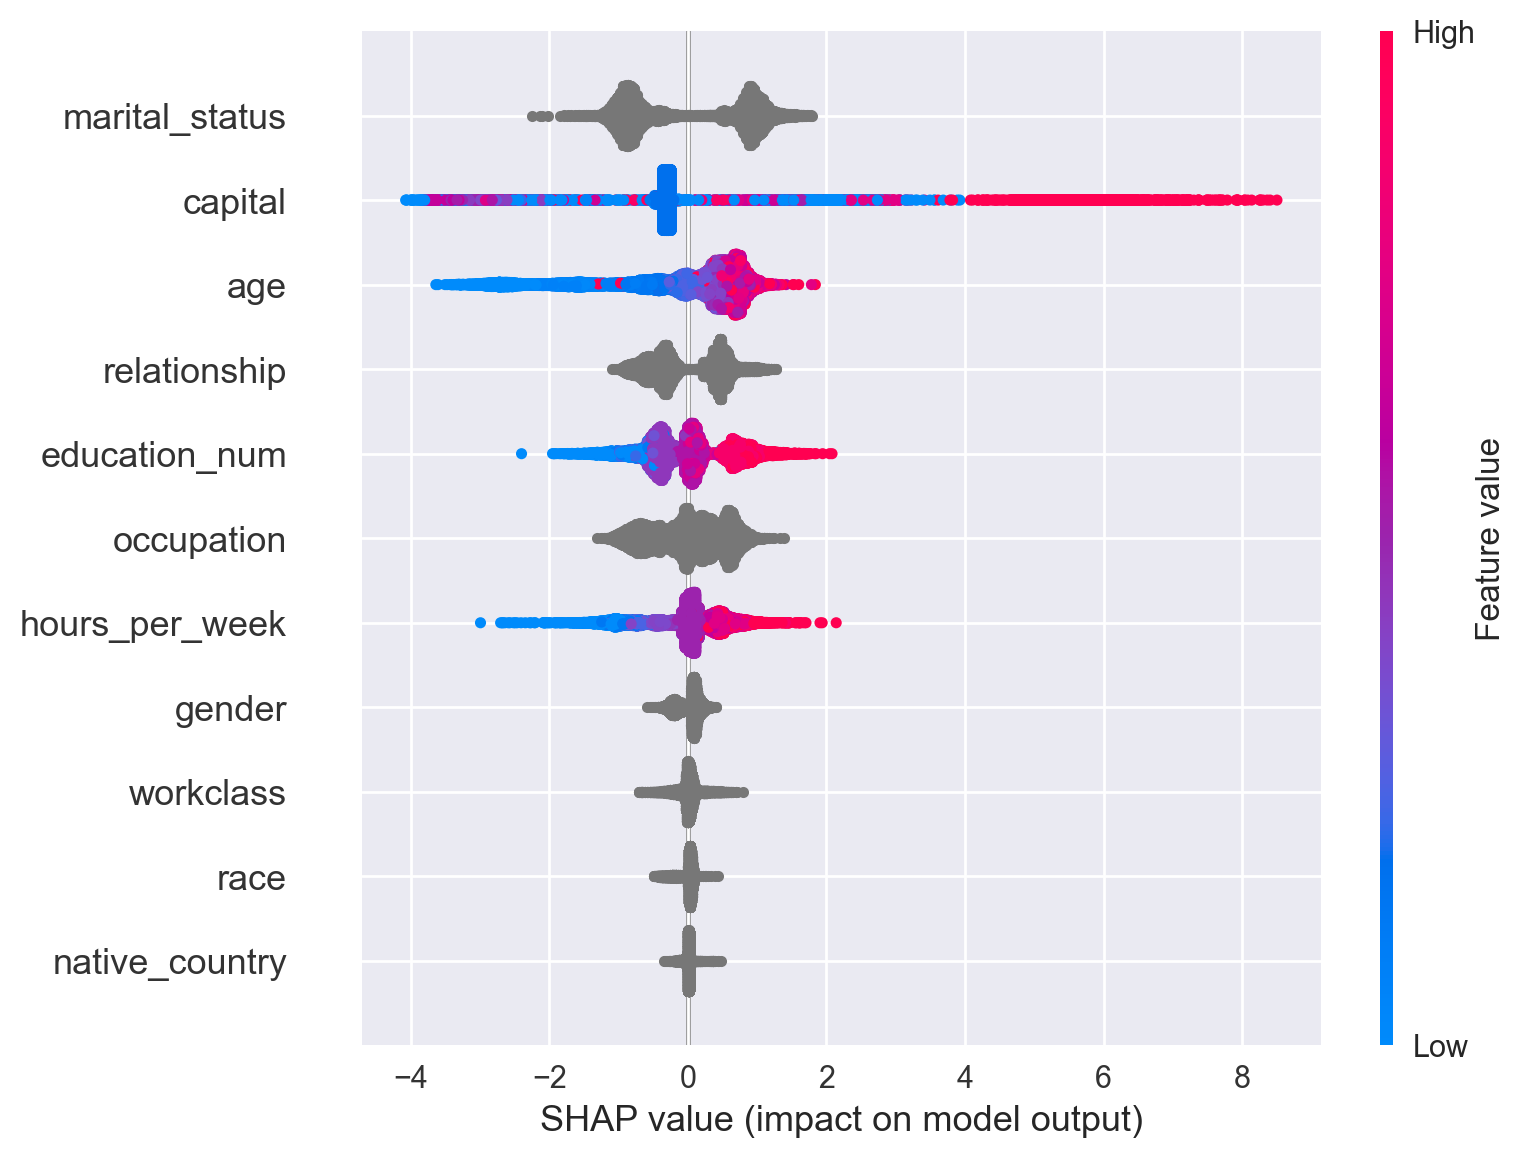

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn-v0_8")

plt.rcParams["figure.figsize"] = (10,6)

explainer = shap.TreeExplainer(clf) 
shap_values = explainer.shap_values(Data_train_subset) 
shap.summary_plot(shap_values, Data_train_subset) 

### Visualisation of Tuning Progress

In [45]:
# !pip install plotly

from optuna.visualization import plot_optimization_history

plot_optimization_history(optuna_study)

### Visualisation of Hyper-parameter Importances

In [46]:
from optuna.visualization import plot_param_importances

plot_param_importances(optuna_study)

***